<a href="https://colab.research.google.com/github/fabioachacon/Coursera_Projects/blob/master/Facial_keypoints_fab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [0]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Useful routines for preparing data
import numpy as np
from pandas import read_csv
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os

In [0]:
def load_imgs_and_keypoints(dirname= '/content/drive/My Drive/data/images'):
    # Write your code for loading images and points here
    data = read_csv('/content/drive/My Drive/data/gt.csv')
    points = data.iloc[:, 1:]
    file_names = sorted(os.listdir(dirname))
    
    images = np.zeros(shape=(len(file_names), 100, 100, 3))
    
    for idx, file in enumerate(file_names):
        image = imread(join(dirname, file))
        
        # Scale all coordinates to range [-0.5, 0.5]
        points.iloc[idx, 0::2] = points.iloc[idx, 0::2].apply(lambda x : (x / image.shape[1]) - .5)
        points.iloc[idx, 1::2] = points.iloc[idx, 1::2].apply(lambda x : (x / image.shape[0]) - .5)
        
        resized = resize(image, [100, 100, 3], mode='constant')
        images[idx] = resized
    
    return images, points.values

imgs, points = load_imgs_and_keypoints()

In [0]:
np.save('/content/drive/My Drive/data/images_array.npy', imgs)
np.save('/content/drive/My Drive/data/points_array.npy', points)

In [0]:
# Load tensors
imgs = np.load('/content/drive/My Drive/data/images_array.npy')
points = np.load('/content/drive/My Drive/data/points_array.npy')

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

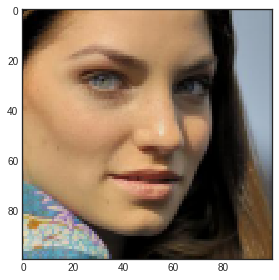

In [4]:
# Example of output
%matplotlib inline
from skimage.io import imshow
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

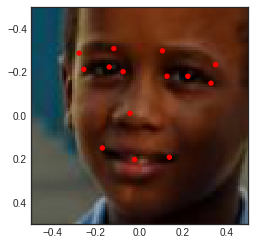

In [5]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    ax.imshow(img, extent=(-.5, .5, .5, -.5))
    
    point = np.array([point for point in zip(points[0::2], points[1::2])])
    
    for pt in point:
        circle = Circle(pt, 0.01, color='r')
        ax.add_patch(circle)
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

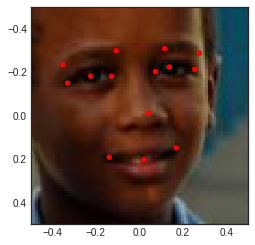

In [7]:
def flip_img(img, points):
    # Write your code for flipping here   
    
    vector_points = np.array([point for point in zip(points[1::2], points[0::2])])
    
    # Rotation Matrix
    R = lambda tetha : np.array([[np.cos(tetha), -np.sin(tetha)],
                                 [np.sin(tetha),  np.cos(tetha)]], dtype=np.int)

    rotated_point = np.zeros(vector_points.shape)
    for idx, component in enumerate(vector_points):
        rotated_point[idx] = np.dot(R(np.pi/2), component)
    
    return np.fliplr(img), rotated_point.flatten()

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
# Write your code here
flipped_images = np.zeros(imgs_train.shape)
flipped_points = np.zeros(points_train.shape)
for idx, (img, point) in enumerate(zip(imgs_train, points_train)):
    flipped_images[idx], flipped_points[idx] = flip_img(img, point)
    
aug_imgs_train = np.array([image for image in zip(imgs_train, flipped_images)])
aug_imgs_train = aug_imgs_train.reshape(aug_imgs_train.shape[0]*2, 100, 100, 3)

aug_points_train = np.array([point for point in zip(points_train, flipped_points)])
aug_points_train = aug_points_train.reshape(aug_points_train.shape[0]*2, 28)

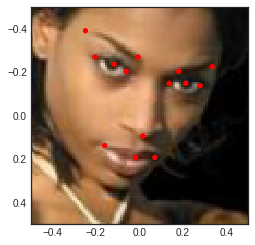

In [23]:
visualize_points(aug_imgs_train[4], aug_points_train[4])

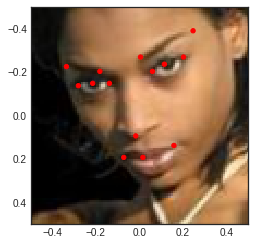

In [24]:
visualize_points(aug_imgs_train[5], aug_points_train[5])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [29]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout 
)

# Define here your model

model = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Conv2D(128, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dropout(0.5),
                    Dense(500, activation='relu'),
                    Dense(500, activation='relu'),
                    Dense(28,  activation='linear')])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 128)       0         
_____

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [0]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training

checkpoint = ModelCheckpoint('/content/drive/My Drive/models/facial_keypoints.h5',
                             monitor='train_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

callback_list = [checkpoint]


model.compile(loss='mse',
              optimizer=Adam())

# Validation examples will not be used to make model selection,
# but only to visualize the results.

hist = model.fit(aug_imgs_train,
                 aug_points_train,
                 epochs=70,
                 batch_size=312,
                 callbacks=callback_list)

Epoch 1/70
10800/10800 [==============================] - 4s 366us/step - loss: 0.0231
Epoch 2/70
  624/10800 [>.............................] - ETA: 2s - loss: 0.0189

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with train_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10800/10800 [==============================] - 3s 284us/step - loss: 0.0187
Epoch 3/70
10800/10800 [==============================] - 3s 283us/step - loss: 0.0180
Epoch 4/70
10800/10800 [==============================] - 3s 284us/step - loss: 0.0176
Epoch 5/70
10800/10800 [==============================] - 4s 345us/step - loss: 0.0172
Epoch 6/70
10800/10800 [==============================] - 3s 286us/step - loss: 0.0167
Epoch 7/70
10800/10800 [==============================] - 3s 286us/step - loss: 0.0164
Epoch 8/70
10800/10800 [==============================] - 3s 287us/step - loss: 0.0160
Epoch 9/70
10800/10800 [==============================] - 3s 284us/step - loss: 0.0157
Epoch 10/70
10800/10800 [==============================] - 3s 284us/step - loss: 0.0153
Epoch 11/70
10800/10800 [==============================] - 3s 286us/step - loss: 0.0150
Epoch 12/70
10800/10800 [==============================] - 3s 286us/step - loss: 0.0145
Epoch 13/70
10800/10800 [==========================

In [0]:
train_loss = hist.history['loss']
epochs = range(1, 1 + len(train_loss))

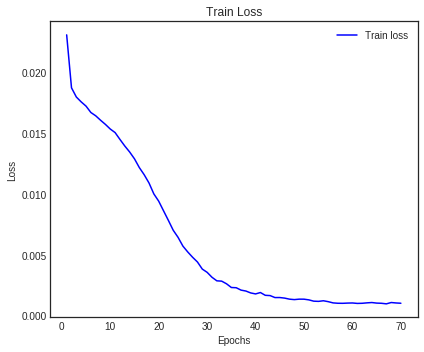

In [0]:
def loss_val_curves(epochs=0.0, train_loss=0.0):
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, train_loss, color='blue', label='Train loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
loss_val_curves(epochs, train_loss)

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [0]:
from random import randint
def visualize_results(model, show=False):
  img = imgs_val[randint(0, 599)].reshape((1,100,100,3))
  prediction = model.predict(img).flatten()
  img = img.reshape(100, 100, 3)
  if show:
    visualize_points(img, prediction)

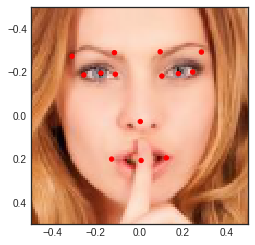

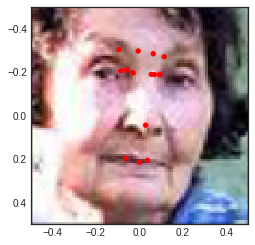

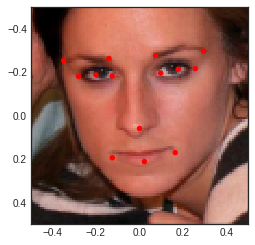

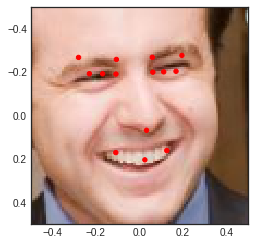

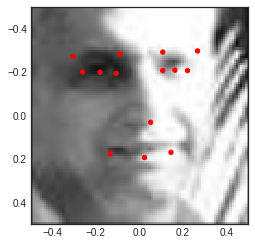

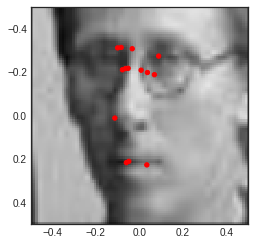

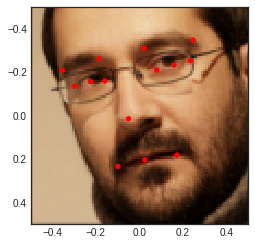

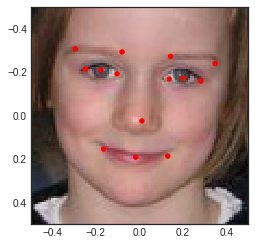

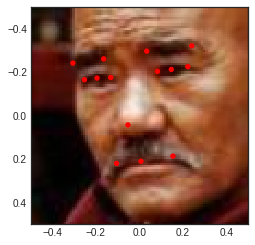

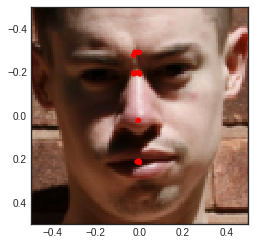

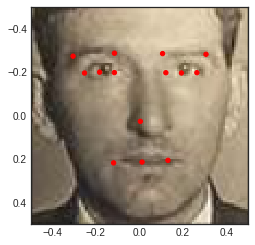

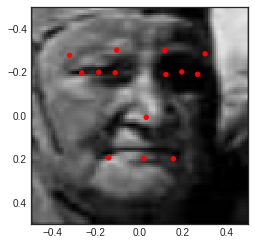

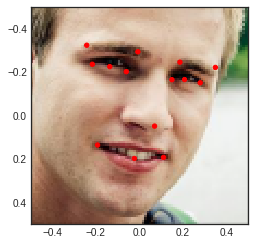

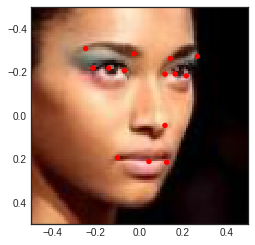

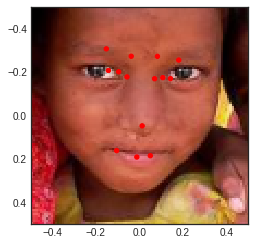

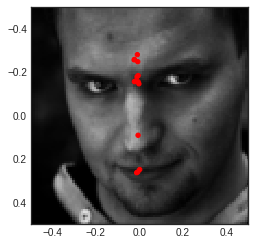

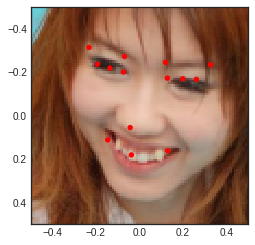

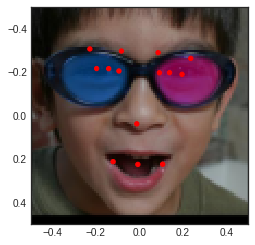

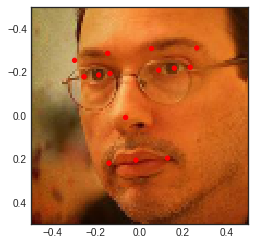

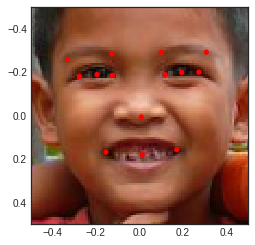

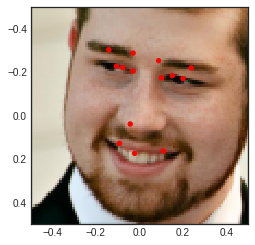

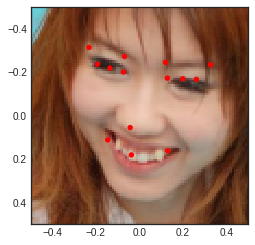

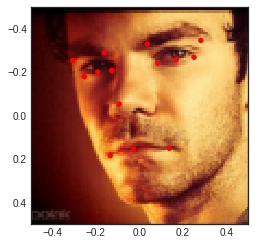

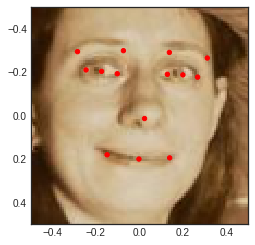

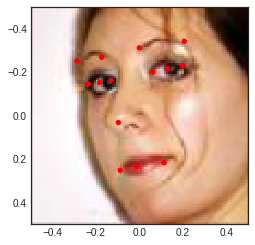

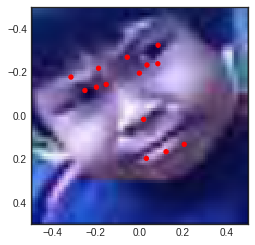

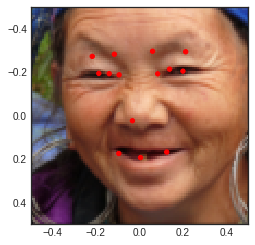

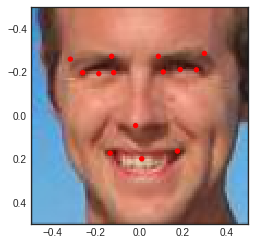

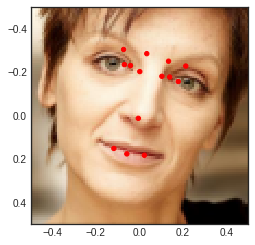

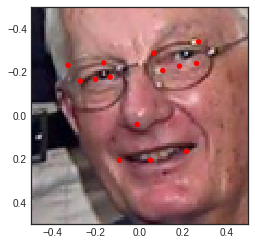

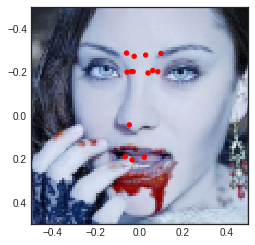

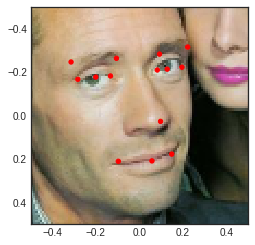

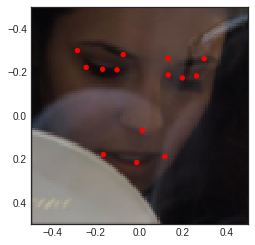

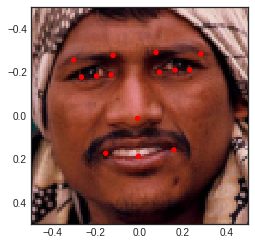

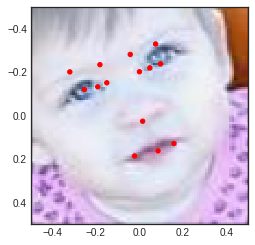

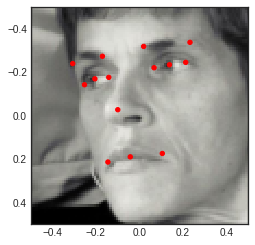

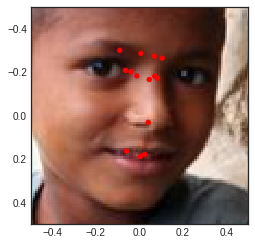

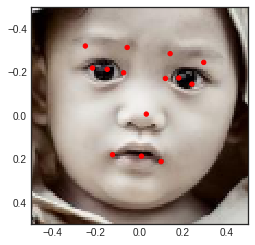

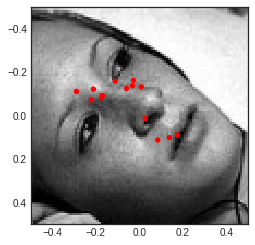

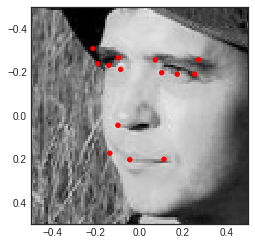

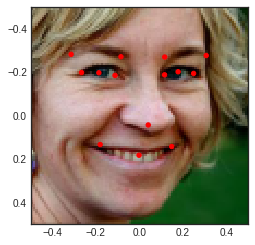

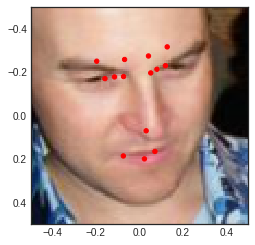

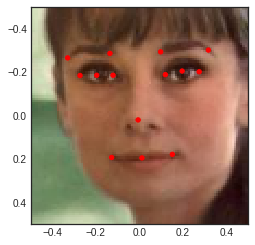

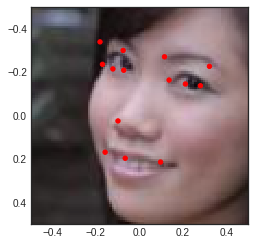

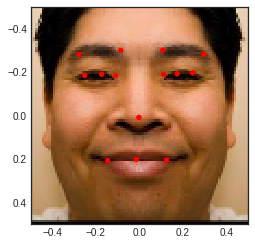

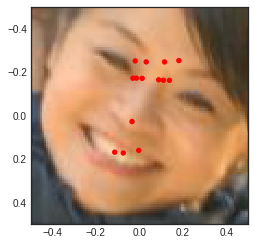

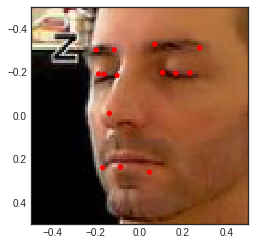

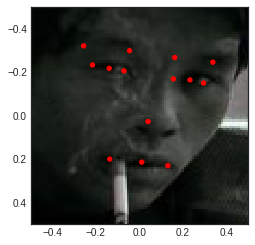

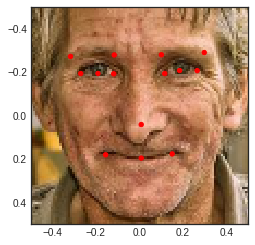

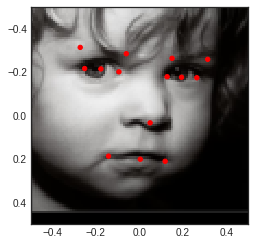

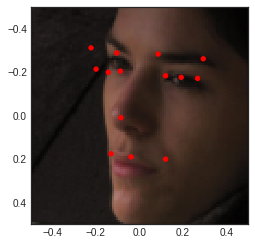

In [0]:
for _ in range(51):
  visualize_results(model, True)

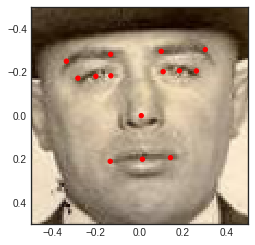

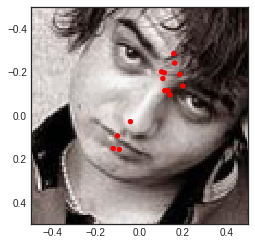

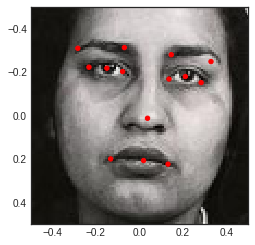

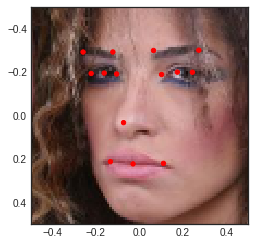

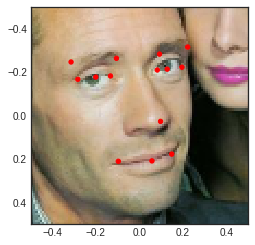

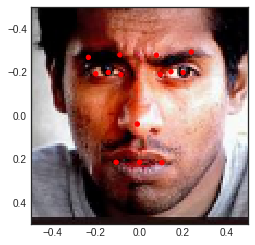

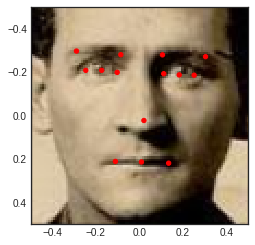

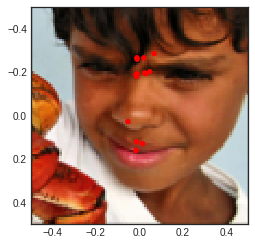

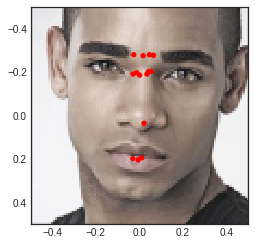

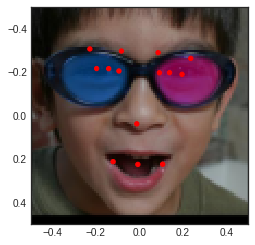

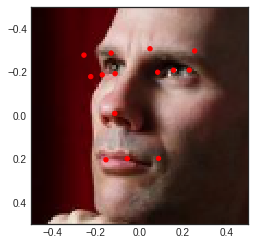

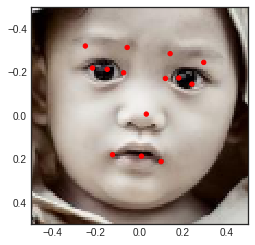

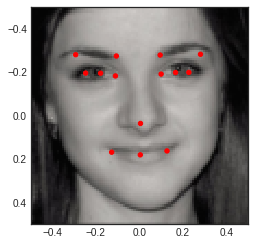

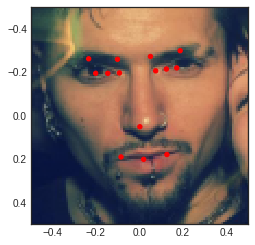

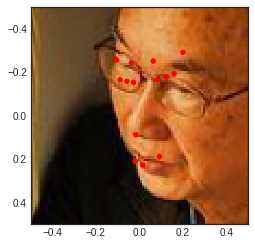

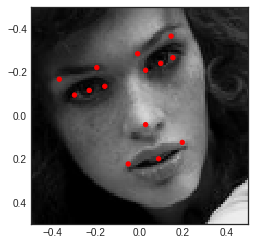

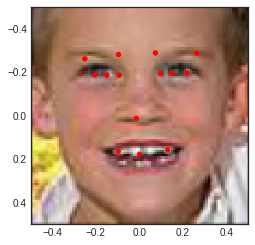

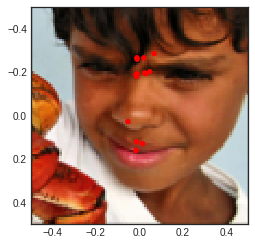

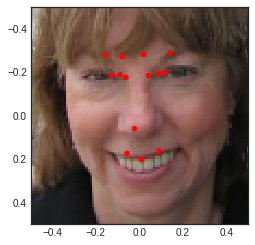

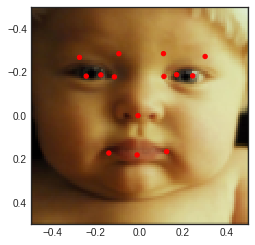

In [0]:
for _ in range(20):
  visualize_results(model, True)

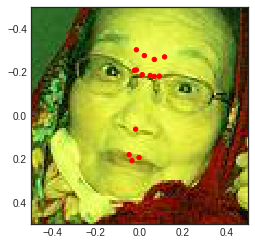

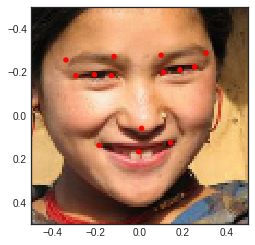

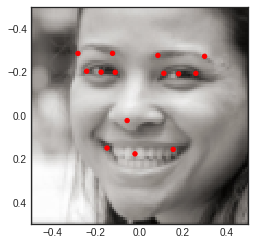

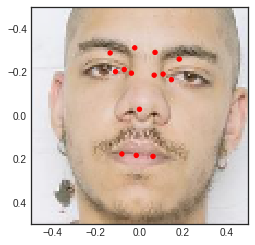

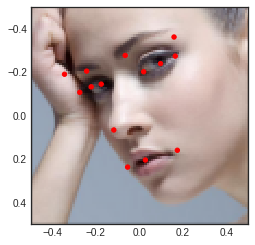

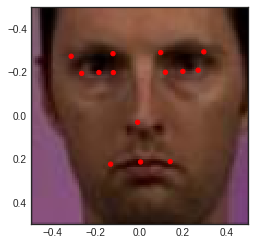

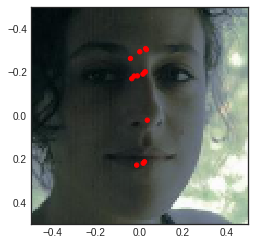

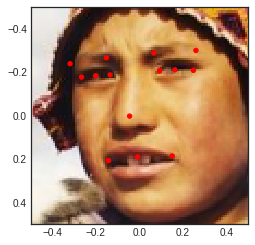

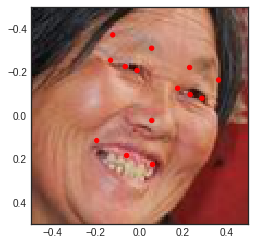

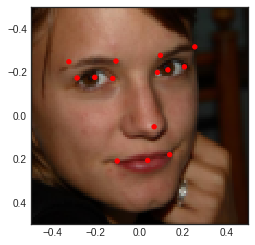

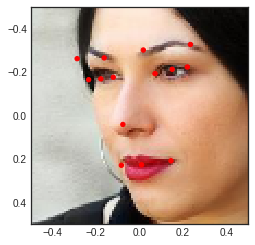

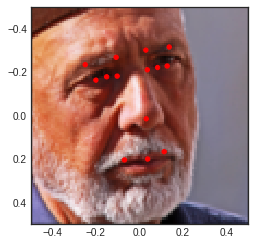

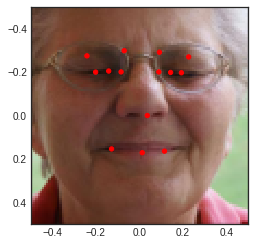

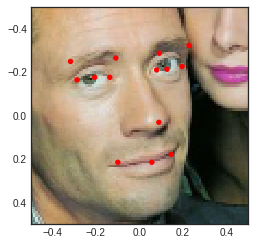

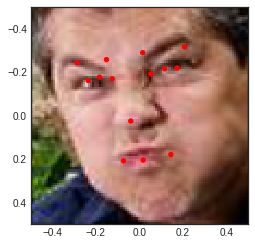

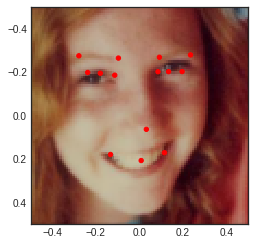

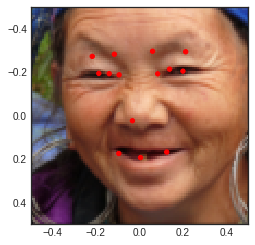

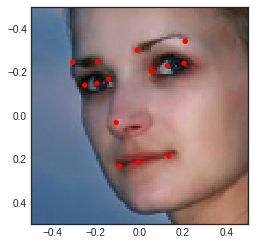

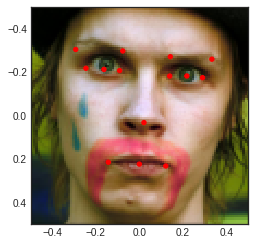

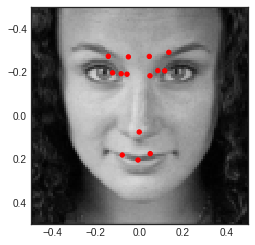

In [0]:
for _ in range(20):
  visualize_results(model, True)